In [41]:
import nideconv
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

reg = re.compile('.*/(?P<ds>ds-[0-9]+)/sub-(?P<subject>[0-9]+)_run-(?P<run>[0-9]+).csv')
fns = glob.glob('./extracted_signals/ds-*/sub-*.csv')

In [42]:
df = []

for fn in fns:
    
    if reg.match(fn):
    
        d = pd.read_csv(fn, index_col=0)#.to_frame('signal')
        meta = reg.match(fn).groupdict()

        for key in meta:
            d[key] = meta[key]

        d.index.name = 't'
        d.reset_index()
        d['subject'] = d.apply(lambda row: '{subject}'.format(**row.to_dict()), 1)
        
        
#        d['mask'] = d.apply(lambda row: '{mask}-{subroi}'.format(**row.to_dict()), 1)
#         d.drop('ds', 1, inplace=True)
        df.append(d)
    
df = pd.concat(df).reset_index()
df['subject'] = df['subject'].astype(int)
df.loc[df['ds']=='ds-02', 'subject'] += df.loc[df['ds']=='ds-01', 'subject'].max()
df['run'] = df['run'].astype(int)
del df['ds']
df = df.set_index(['subject', 'run', 't']).sort_values(['subject', 'run', 't'])
df.head()

rM1       lM1
subject run t                     
1       1   0  -1.948765 -1.103240
            3  -3.989875 -3.164180
            6  -3.854609 -3.013826
            9  -3.746321 -3.066127
            12 -3.273170 -2.435312

In [43]:
reg = re.compile('.*/(?P<ds>ds-[0-9]+)/.*/sub-(?P<subject>[0-9]+)_task-randomdotmotion_run-(?P<run>[0-9]+)_events.tsv')

In [44]:
## get events
behavior = pd.read_pickle('./derivatives/behavior.pkl')
behavior['sub'] = behavior['subject']
behavior.loc[behavior['ds']=='ds-02', 'sub'] = behavior.loc[behavior['ds']=='ds-02', 'sub'].astype(int) + behavior.loc[behavior['ds']=='ds-01', 'sub'].astype(int).max()
behavior['sub'] = behavior['sub'].astype(int)
behavior['onset_response'] = behavior['onset_stim'] + behavior['rt']/1000
behavior = behavior.loc[behavior.response.isin([1,2])]  # remove errors

events_cue = behavior[['sub', 'block', 'cue', 'onset_cue']]
events_cue['event_type'] = events_cue['cue'].apply(lambda x: 'cue_' + x)
events_cue = events_cue.rename(columns={'block': 'run', 'onset_cue': 'onset'})

events_stim = behavior[['sub', 'block', 'difficulty', 'onset_stim']]
events_stim = events_stim.rename(columns={'block': 'run', 'onset_stim': 'onset', 'difficulty': 'event_type'})

events_responses = behavior[['sub', 'block', 'response', 'onset_response']]
events_responses['event_type'] = events_responses['response'].replace({1: 'response_left', 2: 'response_right', -1: 'error'})
events_responses = events_responses.rename(columns={'block': 'run', 'onset_response': 'onset'})

events = pd.concat((events_cue, events_stim, events_responses))
events = events.sort_values(by=['sub', 'run', 'onset'])
events = events.rename(columns={'sub': 'subject'})

events = events.set_index(['subject', 'run'])[['onset', 'event_type']]#.rename(columns={'event_type': 'trial_type'})
events['duration'] = 0.001
events.head()

# ## correct onsets due to STC
events['onset'] -= 1.5
events.head()

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



onset     event_type  duration
subject run                                 
1       1     6.000       cue_left     0.001
        1     8.750           easy     0.001
        1     9.821  response_left     0.001
        1    15.000       cue_left     0.001
        1    17.750           hard     0.001

In [45]:
## get confounds
all_csvs = glob.glob('./derivatives/ds-*/fmriprep/sub*/func/sub-*_task-randomdotmotion_run-*_desc-confounds_regressors.tsv')

reg = re.compile('.*ds-(?P<ds>\d+)/fmriprep/sub-.*/func/sub-(?P<sub>\d+)_.*_run-(?P<run>\d+)_.*')
reg.match(all_csvs[1]).groupdict()

confounds_df = []

# loop over .csv-files, adding signal row-by-row
for fn in all_csvs:
    d = reg.match(fn).groupdict()
    tmp = pd.read_csv(fn, sep='\t')
    tmp['sub'] = d['sub']
    tmp['run'] = d['run']
    tmp['ds'] = d['ds']
    confounds_df.append(tmp)

confounds_df = pd.concat(confounds_df, axis=0)
confounds_df['ds'] = confounds_df['ds'].astype(int)
confounds_df['run'] = confounds_df['run'].astype(int)
confounds_df['subject'] = confounds_df['sub'].astype(int)

# adjust ds2 subject idx to ensure non-overlapping subject idx
max_sub_ds1 = confounds_df.loc[confounds_df.ds==1,'subject'].max()
confounds_df.loc[confounds_df.ds==2,'subject'] = confounds_df.loc[confounds_df.ds==2,'subject']+max_sub_ds1
confounds_df = confounds_df.sort_values(['ds', 'subject', 'run']).set_index(['ds', 'subject', 'run'])

# Include confounds: 5 ACompCor regressors, cosines for drift, DVARS, rotation & translation params
confounds_deconv = confounds_df.reset_index(level=0, drop=True)
include_confounds = ['a_comp_cor_0' + str(x) for x in range(5)] + ['cosine' + str(x).zfill(2) for x in range(17)]
include_confounds = include_confounds + ['dvars', 'framewise_displacement']
include_confounds = include_confounds + ['rot_' + a for a in ['x', 'y', 'z']]
include_confounds = include_confounds + ['trans_' + a for a in ['x', 'y', 'z']]
confounds_deconv = confounds_deconv[include_confounds]
confounds_deconv.head()

<>:4: DeprecationWarning: invalid escape sequence \d
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



a_comp_cor_00  a_comp_cor_01  a_comp_cor_02  a_comp_cor_03  \
subject run                                                               
1       1        -0.044264       0.059630      -0.048303       0.070233   
        1        -0.159348       0.053665       0.088146      -0.008486   
        1        -0.152059       0.014026       0.023119      -0.067522   
        1        -0.083787      -0.014693       0.005224      -0.044889   
        1        -0.014454      -0.024021      -0.049482      -0.046033   

             a_comp_cor_04  cosine00  cosine01  cosine02  cosine03  cosine04  \
subject run                                                                    
1       1        -0.244679  0.071888  0.071886  0.071883  0.071879  0.071874   
        1        -0.184745  0.071883  0.071867  0.071841  0.071803  0.071755   
        1        -0.101028  0.071874  0.071829  0.071755  0.071652  0.071519   
        1        -0.002374  0.071860  0.071772  0.071628  0.071425  0.071164   
        1         0.044069  0.071841  0.071697  0.071457  0.071122  0.070693   

             ...  cosine15  cosine16      dvars  framewise_displacement  \
subject run  ...                                                          
1       1    ...  0.071737  0.071717        NaN                     NaN   
        1    ...  0.070528  0.070354  29.408150                0.106529   
        1    ...  0.068132  0.067652  21.839451                0.055383   
        1    ...  0.064587  0.063665  20.462967                0.040175   
        1    ...  0.059955  0.058466  20.429110                0.054571   

                rot_x     rot_y     rot_z   trans_x   trans_y   trans_z  
subject run                                                              
1       1    0.001524  0.000356 -0.000161 -0.082265 -0.115355  0.062333  
        1    0.000932  0.000164  0.000000 -0.070083 -0.092359  0.086446  
        1    0.000673  0.000346 -0.000137 -0.065494 -0.095517  0.105258  
        1    0.000511  0.000322 -0.000230 -0.059378 -0.081704  0.098941  
        1    0.000099  0.000239 -0.000194 -0.051345 -0.065291  0.095407  

[5 rows x 30 columns]

## Responses left/right

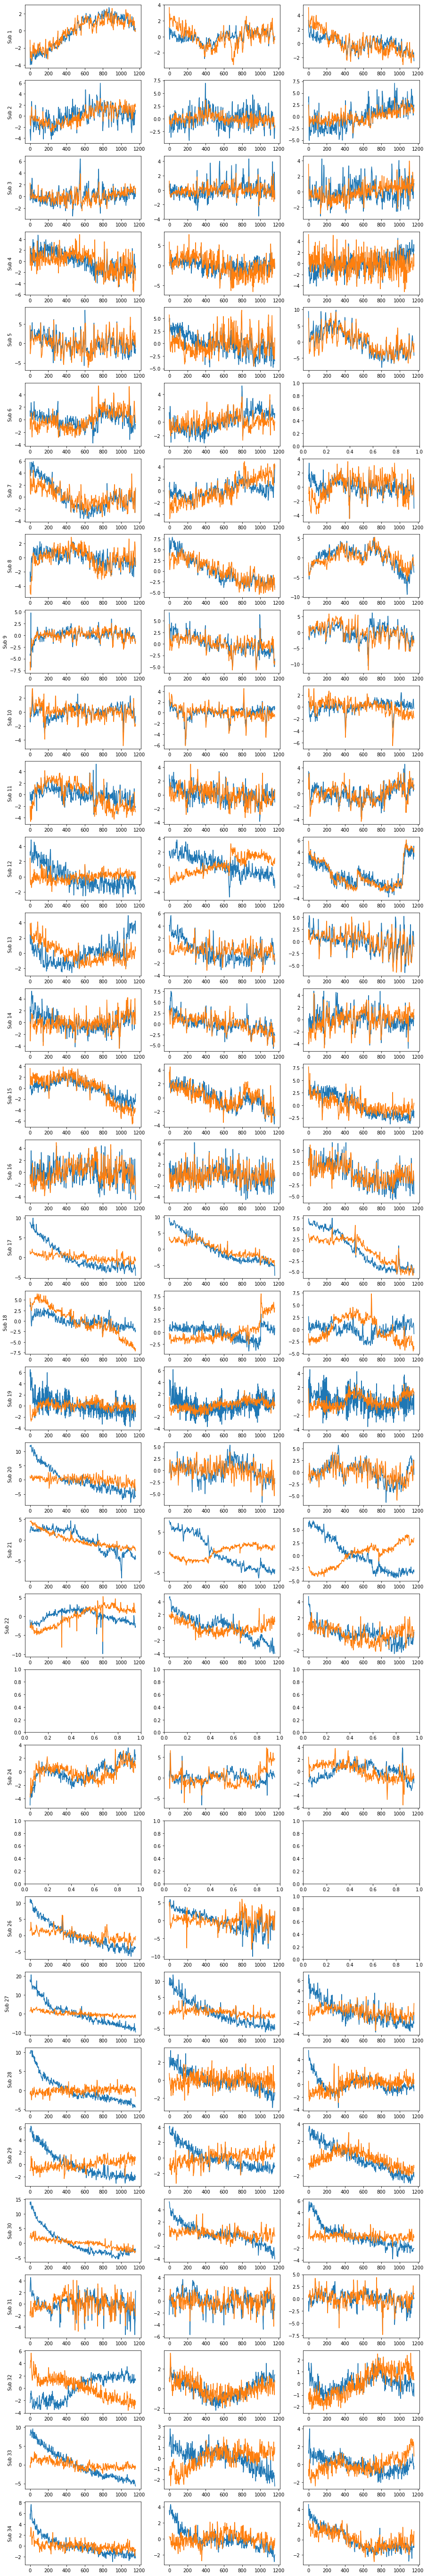

In [46]:
f, ax = plt.subplots(34, 3)
for sub in df.reset_index()['subject'].unique():
    for run in df.loc[sub].reset_index()['run'].unique():
        ax[sub-1,run-1].plot(df.loc[sub, run])
    ax[sub-1,0].set_ylabel('Sub {}'.format(sub))
    
f.set_size_inches(15, 100)

## Deconvolve overall, include cue and stim in model

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


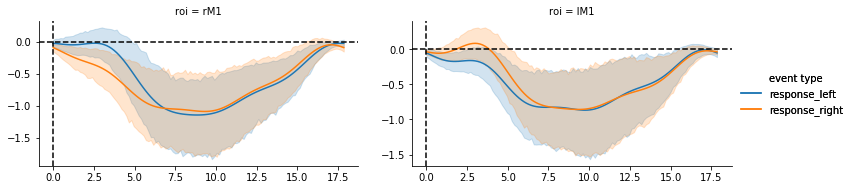

In [47]:
events_ = events.copy()
events_.loc[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral']), 'event_type'] = 'cue'
events_.loc[events_['event_type'].isin(['easy', 'hard']), 'event_type'] = 'stim'
#events_ = events_[events_['event_type'].isin(['response_left', 'response_right'])]
del events_['duration']

gf = nideconv.GroupResponseFitter(df, events_, 1/3., confounds=confounds_deconv.fillna(0).reset_index())
gf.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('stim', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['response_left', 'response_right'],
                              ci=95, plots='covariate', col='roi', col_wrap=2)

## exclude cue & stim from model

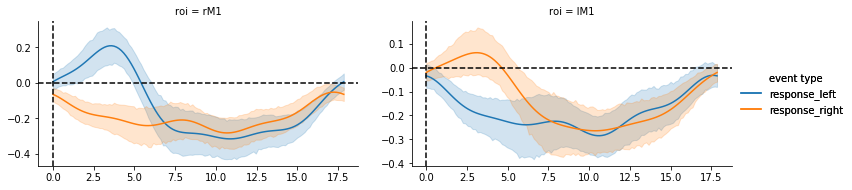

In [48]:
events_ = events.copy()
#events_.loc[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral']), 'event_type'] = 'cue'
#events_.loc[events_['event_type'].isin(['easy', 'hard']), 'event_type'] = 'stim'
events_ = events_[events_['event_type'].isin(['response_left', 'response_right'])]
del events_['duration']

gf = nideconv.GroupResponseFitter(df, events_, 1/3., confounds=confounds_deconv.fillna(0))
#gf.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=9)
#gf.add_event('stim', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['response_left', 'response_right'],
                              ci=95, plots='covariate', col='roi', col_wrap=2)

## Leipzig

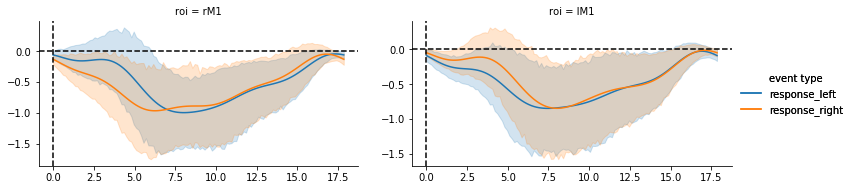

In [49]:
events_ = events.copy().loc[:19]
events_.loc[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral']), 'event_type'] = 'cue'
events_.loc[events_['event_type'].isin(['easy', 'hard']), 'event_type'] = 'stim'
del events_['duration']
df_ = df.loc[:19]
confounds_ = confounds_deconv.copy().loc[:19]
#events_['onset'] -= 1.5

gfL1 = nideconv.GroupResponseFitter(df_, events_, 1/3., confounds=confounds_.fillna(0).reset_index(), 
                                  oversample_design_matrix=20)
gfL1.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfL1.add_event('stim', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfL1.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfL1.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)

gfL1.fit()
gfL1.plot_groupwise_timecourses(event_types=['response_left', 'response_right'], #, 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)

Without stims & cues

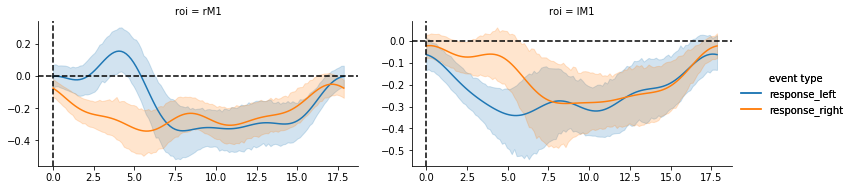

In [50]:
events_ = events.copy().loc[:19]
events_ = events_[events_['event_type'].isin(['response_left', 'response_right'])]
del events_['duration']
df_ = df.loc[:19]
confounds_ = confounds_deconv.copy().loc[:19]
# events_['onset'] += 1.5

# for sub in np.arange(1,20):
#     if sub in [2,3,16]:
#         ## sequential decreasing?
#         events_.loc[sub, 'onset'] = events_.loc[sub, 'onset'].values     #+ 1.5
#     else:
#         ## sequential increasing?
#         events_.loc[sub, 'onset'] = events_.loc[sub, 'onset'].values #- 3 #1.5

gfL2 = nideconv.GroupResponseFitter(df_, events_, 1/3., confounds=confounds_.reset_index(), 
                                  oversample_design_matrix=20, concatenate_runs=True)
gfL2.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfL2.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)

gfL2.fit()
gfL2.plot_groupwise_timecourses(event_types=['response_left', 'response_right'], #, 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)

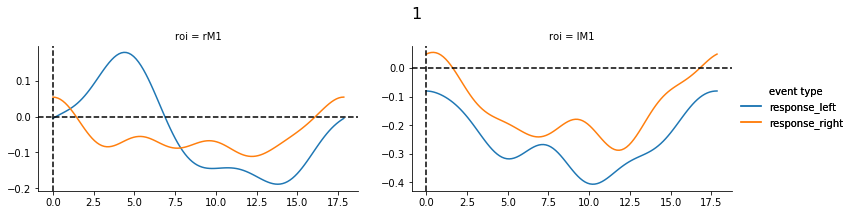

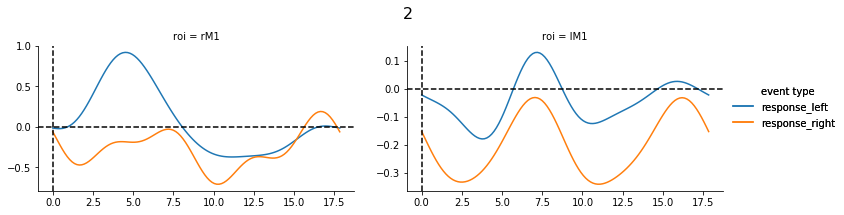

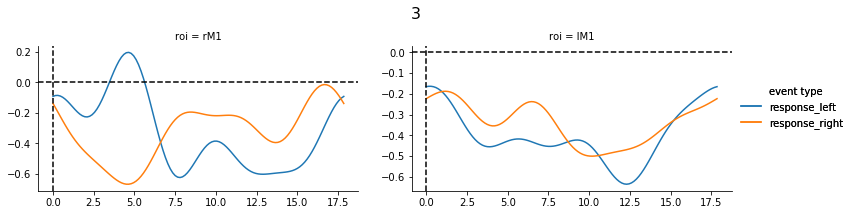

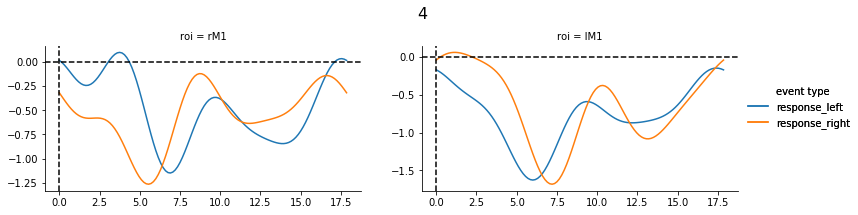

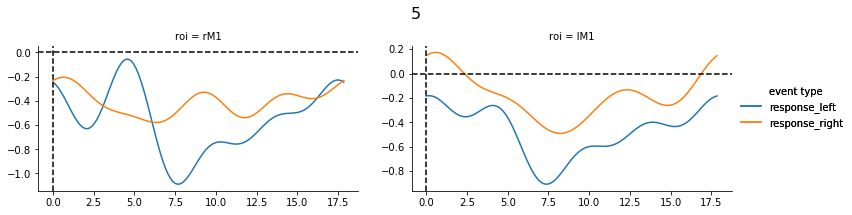

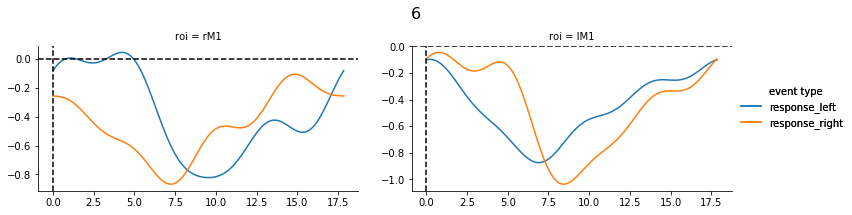

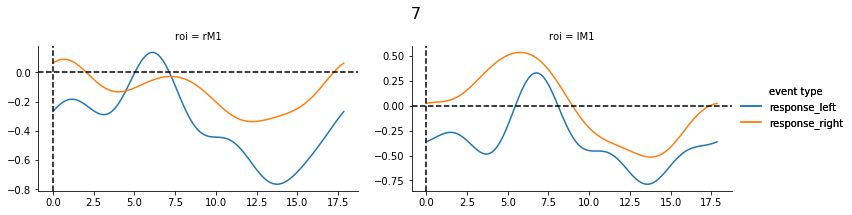

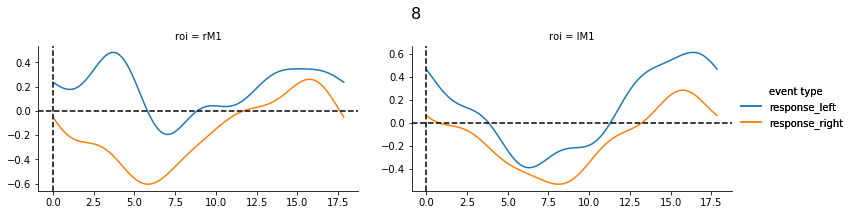

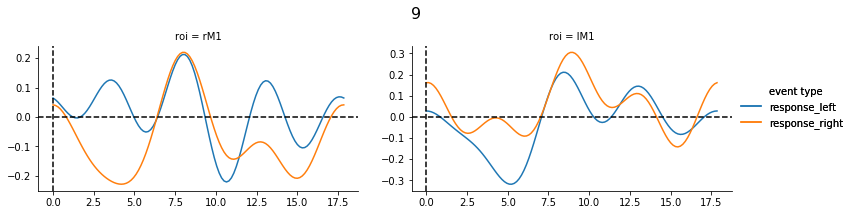

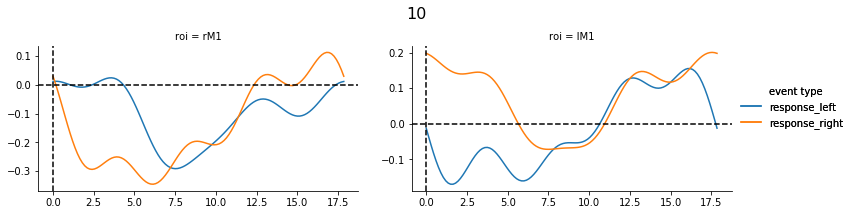

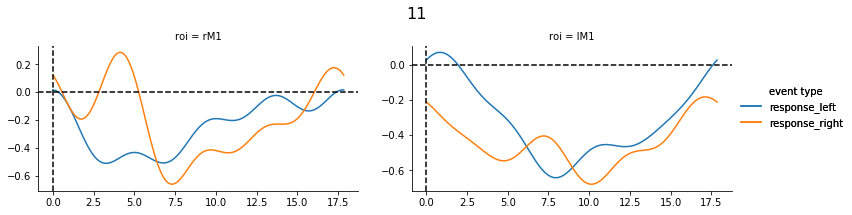

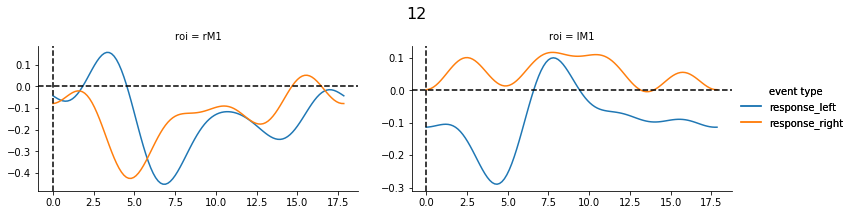

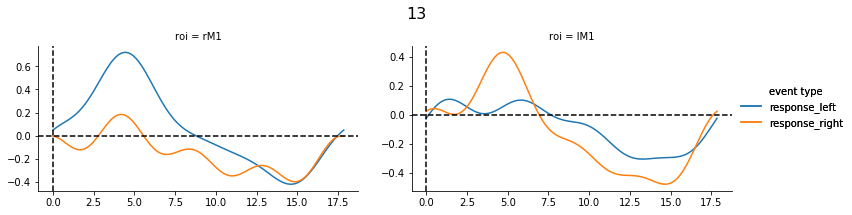

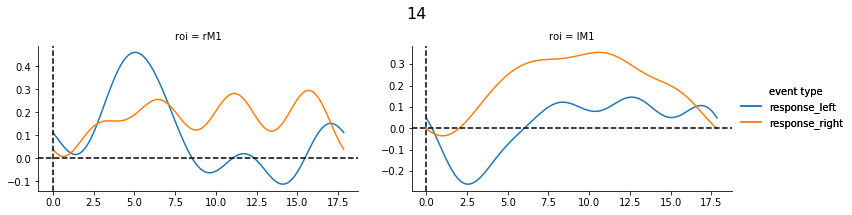

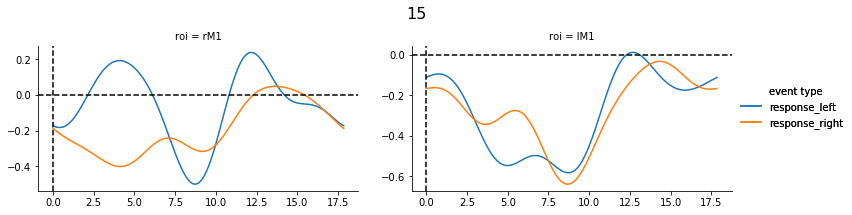

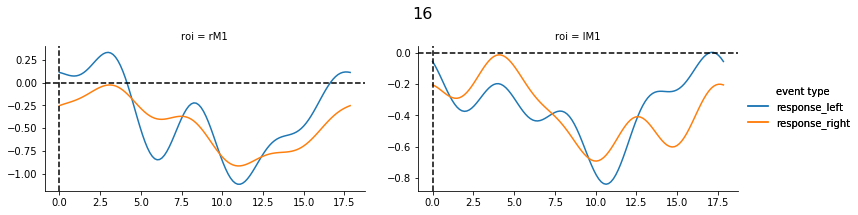

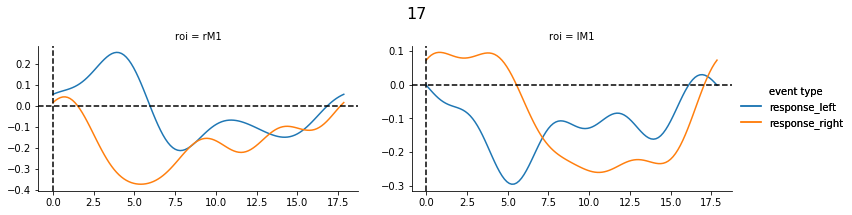

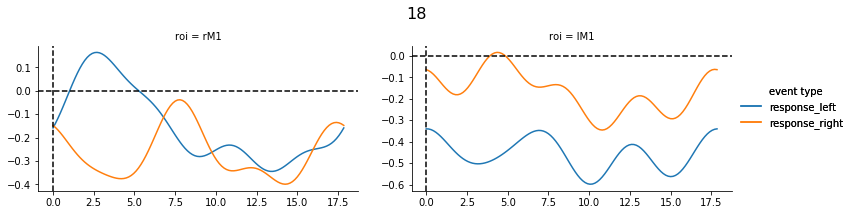

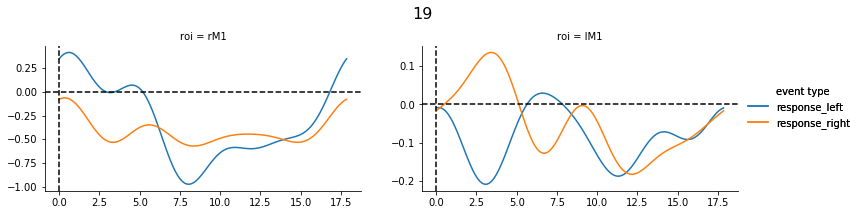

In [51]:
gfL2.plot_subject_timecourses(event_types=['response_left', 'response_right'], 
                              row=None, col='roi', plots='subject', col_wrap=None)

In [52]:
lM1 = gfL2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['lM1'].reset_index(level=[1,2], drop=True))
rM1 = gfL2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['rM1'].reset_index(level=[1,2], drop=True))

In [53]:
pd.concat([rM1['response_left'], lM1['response_right']], axis=1)

,response_left,response_right
subject,,
1,4.35,9.15
2,4.50,7.05
3,4.65,6.45
4,9.75,10.35
5,4.50,12.30
6,4.20,4.50
7,6.15,5.70
8,3.75,15.75
9,7.95,9.00


## Amsterdam

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


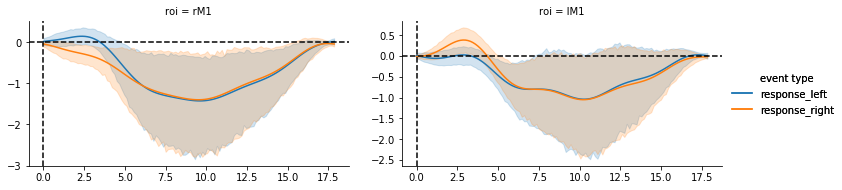

In [54]:
events_ = events.copy().loc[20:]
events_.loc[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral']), 'event_type'] = 'cue'
events_.loc[events_['event_type'].isin(['easy', 'hard']), 'event_type'] = 'stim'
#events_ = events_[events_['event_type'].isin(['response_left', 'response_right'])]
del events_['duration']
df_ = df.loc[20:]
confounds_ = confounds_deconv.copy().loc[20:] #.reset_index()

gfA1 = nideconv.GroupResponseFitter(df_, events_, 1/3., confounds=confounds_.fillna(0).reset_index(), 
                                    oversample_design_matrix=20)
gfA1.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfA1.add_event('stim', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfA1.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfA1.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)

gfA1.fit()
gfA1.plot_groupwise_timecourses(event_types=['response_left', 'response_right'], #, 'stim', 'cue'],
                              ci=95, plots='covariate', col='roi', col_wrap=2)

Without stims & cue

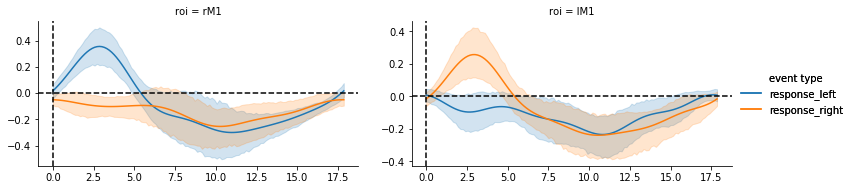

In [55]:
events_ = events.copy().loc[20:]
events_ = events_[events_['event_type'].isin(['response_left', 'response_right'])]
del events_['duration']
df_ = df.loc[20:]
confounds_ = confounds_deconv.copy().loc[20:] #.reset_index()

gfA2 = nideconv.GroupResponseFitter(df_, events_, 1/3., confounds=confounds_.fillna(0).reset_index(), 
                                    oversample_design_matrix=20)
gfA2.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfA2.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)
# gfA2.add_event('response_left', interval=[0, 18], basis_set='fir')#, n_regressors=9)
# gfA2.add_event('response_right', interval=[0, 18], basis_set='fir')#, n_regressors=9)

gfA2.fit()
gfA2.plot_groupwise_timecourses(event_types=['response_left', 'response_right'], #, 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)

In [56]:
lM1 = gfA2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['lM1'].reset_index(level=[1,2], drop=True))
rM1 = gfA2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['rM1'].reset_index(level=[1,2], drop=True))

In [57]:
lM1['response_right'], rM1['response_left']

(subject
 20    3.45
 21    1.50
 22    2.85
 24    3.15
 26    3.75
 27    3.60
 28    8.85
 29    3.00
 30    2.55
 31    5.70
 32    2.85
 33    2.85
 34    5.85
 Name: response_right, dtype: float64, subject
 20     3.15
 21     3.30
 22     2.70
 24    17.55
 26     8.85
 27     3.00
 28     9.00
 29     2.85
 30     2.70
 31     1.35
 32     3.30
 33     2.70
 34     2.55
 Name: response_left, dtype: float64)

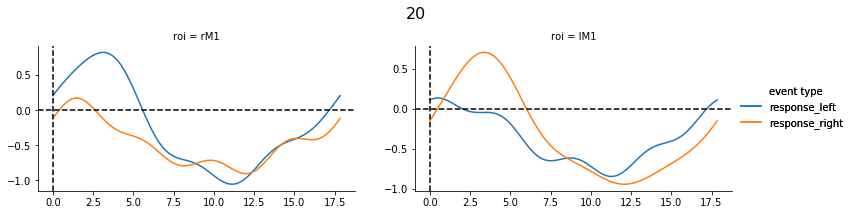

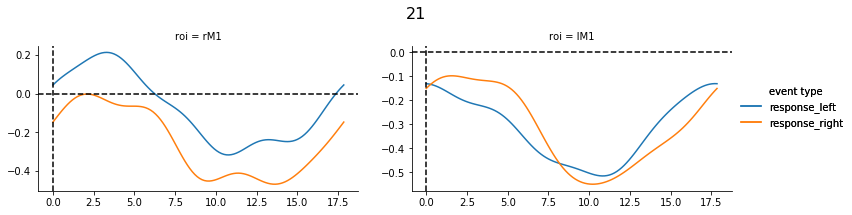

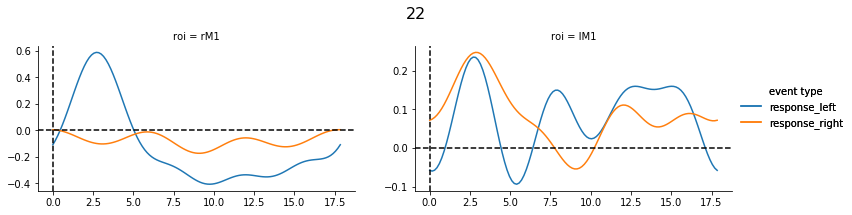

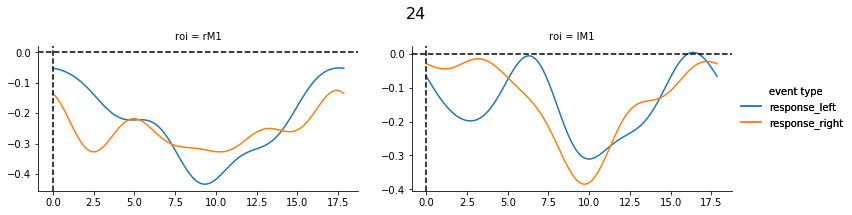

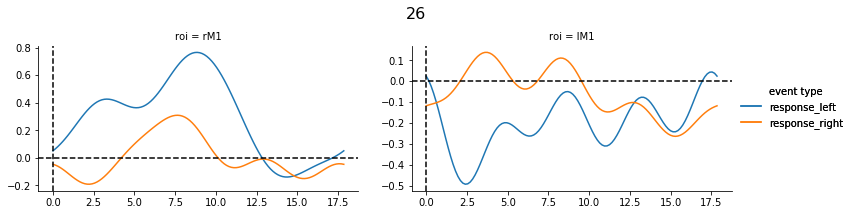

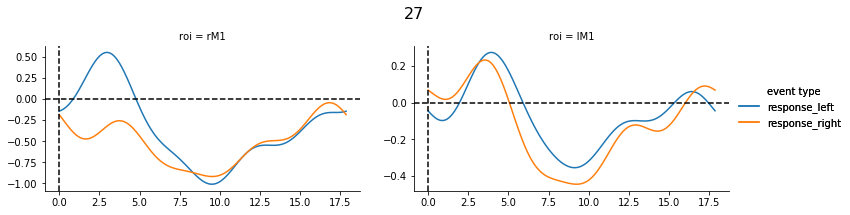

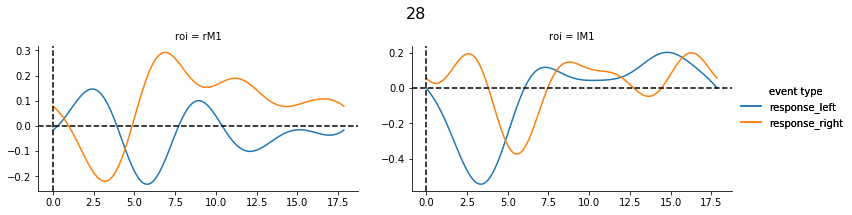

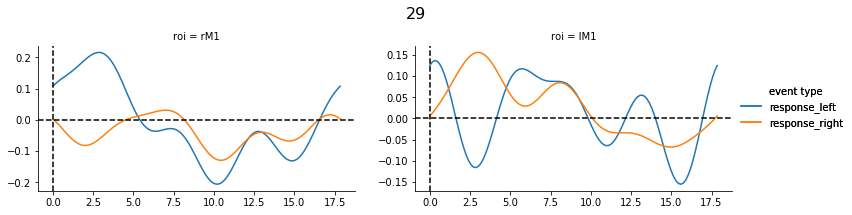

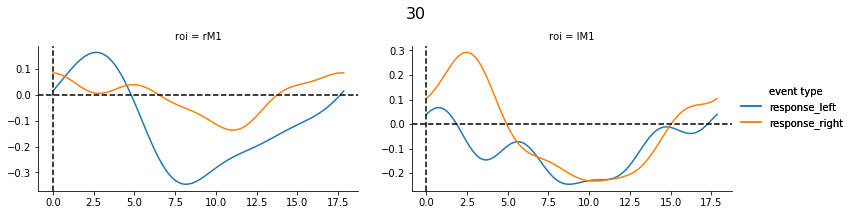

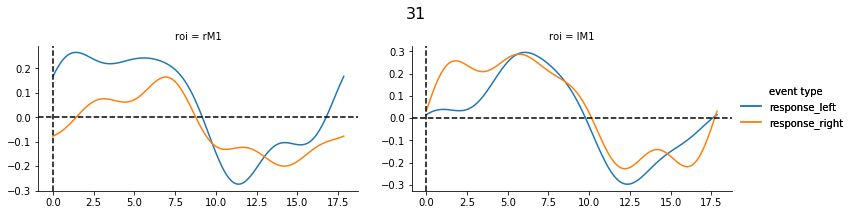

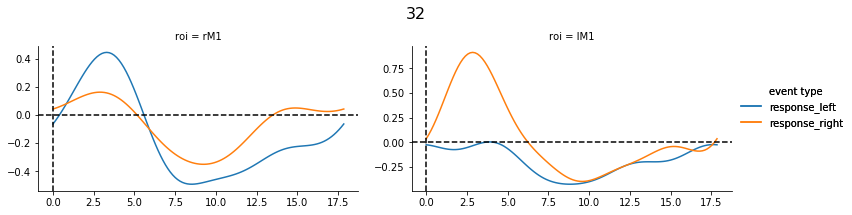

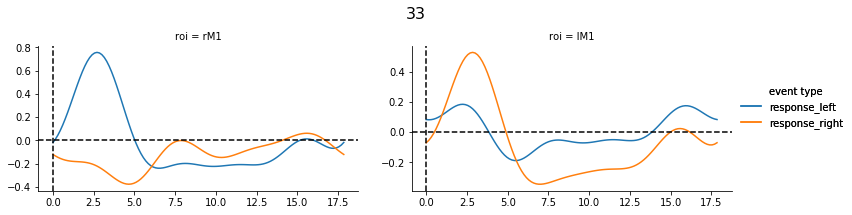

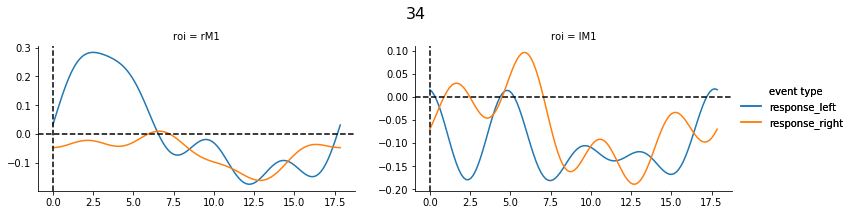

In [58]:
gfA2.plot_subject_timecourses(event_types=['response_left', 'response_right'], row=None, col='roi', plots='subject', col_wrap=None)

Here, the Amsterdam data looks cleaner. Both data sets show the left/right contrast, but there appears to be some sort of negative "bump" in lM1 in the Leipzig data that "pulls" the signal down from baseline.

## sigma2?

In [59]:
sigma2s_ds1 = gfL1._get_response_fitters().apply(lambda x: x.sigma2)
sigma2s_ds2 = gfA1._get_response_fitters().apply(lambda x: x.sigma2)
print(sigma2s_ds1.mean(0))
print(sigma2s_ds2.mean(0))

rM1    1.252156
lM1    1.311050
dtype: float64
rM1    1.492252
lM1    0.904217
dtype: float64


In [60]:
sigma2s_ds1 = gfL2._get_response_fitters().apply(lambda x: x.sigma2)
sigma2s_ds2 = gfA2._get_response_fitters().apply(lambda x: x.sigma2)
print(sigma2s_ds1.mean(0))
print(sigma2s_ds2.mean(0))

rM1    1.254498
lM1    1.308400
dtype: float64
rM1    1.481438
lM1    0.902966
dtype: float64


In [61]:
display(sigma2s_ds1)
display(sigma2s_ds2)

,rM1,lM1
subject,,
1,0.761755,1.289840
2,2.044293,0.568330
3,1.083933,0.495189
4,1.528782,2.394287
5,2.390240,2.797543
6,0.669930,0.511512
7,1.384223,1.640768
8,2.088766,1.843287
9,1.776369,1.816448


,rM1,lM1
subject,,
20,4.286605,1.257958
21,0.802279,1.628629
22,0.916383,1.093200
24,0.703634,0.752709
26,2.198268,1.788827
27,3.205037,0.565037
28,1.403162,0.515053
29,0.280463,0.395398
30,1.876047,0.455392


In [62]:
sigma2s_ds1 = gfL2._get_response_fitters().apply(lambda x: x.sigma2)
sigma2s_ds2 = gfA2._get_response_fitters().apply(lambda x: x.sigma2)

In [63]:
display(sigma2s_ds1)
display(sigma2s_ds2)

print(sigma2s_ds1.mean(0))
print(sigma2s_ds2.mean(0))

,rM1,lM1
subject,,
1,0.761755,1.289840
2,2.044293,0.568330
3,1.083933,0.495189
4,1.528782,2.394287
5,2.390240,2.797543
6,0.669930,0.511512
7,1.384223,1.640768
8,2.088766,1.843287
9,1.776369,1.816448


,rM1,lM1
subject,,
20,4.286605,1.257958
21,0.802279,1.628629
22,0.916383,1.093200
24,0.703634,0.752709
26,2.198268,1.788827
27,3.205037,0.565037
28,1.403162,0.515053
29,0.280463,0.395398
30,1.876047,0.455392


rM1    1.254498
lM1    1.308400
dtype: float64
rM1    1.481438
lM1    0.902966
dtype: float64


## plot full model

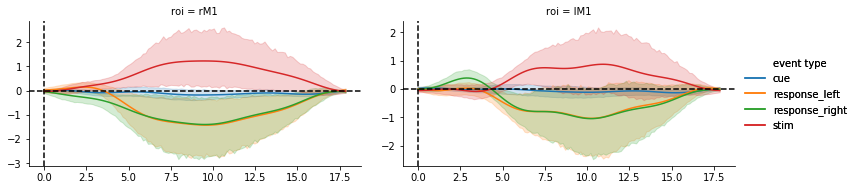

In [64]:
gfA1.plot_groupwise_timecourses(event_types=['response_left', 'response_right', 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)

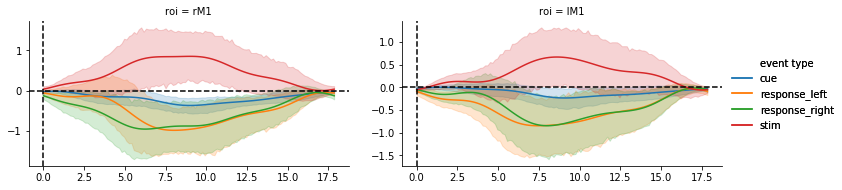

In [65]:
gfL1.plot_groupwise_timecourses(event_types=['response_left', 'response_right', 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)